# Data Preparation Part 1

In [55]:
pip install yellowbrick

  Using cached yellowbrick-1.3.post1-py3-none-any.whl (271 kB)
Note: you may need to restart the kernel to use updated packages.


###  Import Libraries and Alias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, cross_val_score, KFold
from sklearn import metrics
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import RidgeCV, Ridge, LogisticRegression, SGDClassifier
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from mlxtend.evaluate import paired_ttest_5x2cv
import time

### Data Intiation

In [2]:
# Data Init
url="https://raw.githubusercontent.com/bensonnd/msds/master/ds7331/data/hotel_bookings.csv"
hotel = pd.read_csv(url)

### New Features

In [3]:

#add `arrival_date` - converting arrival y/m/d columns to a singular column
hotel['arrival_date'] = pd.to_datetime([f'{y}-{m}-{d}' for y, m, d in zip(hotel.arrival_date_year,
                                                                          hotel.arrival_date_month,
                                                                          hotel.arrival_date_day_of_month)])

    # source:
    # https://stackoverflow.com/questions/54487059/pandas-how-to-create-a-single-date-column-from-columns-containing-year-month

# add `length_of_stay`
    # we will use this as predictor in the classification task, as well as the continuous variable 
    # we want to regress to
hotel['length_of_stay'] = hotel["stays_in_weekend_nights"] + hotel["stays_in_week_nights"]


# set `length_of_stay` as a pandas time delta
length = hotel['length_of_stay'].apply(np.ceil).apply(lambda x: pd.Timedelta(x, unit='D'))

    # source:
    # https://stackoverflow.com/questions/42768649/add-days-to-date-in-pandas

    
# add `departure_date` 
hotel['departure_date'] = hotel['arrival_date'] + length


# add `total_revenue`
hotel["total_revenue"] = abs(hotel["adr"]) * hotel["length_of_stay"]


# add `country_cancelation_rate`
    # first we aggregate number of cancelations per country, then divide by total records per country
    # once we have the rate, we join back on country name
hotel['is_canceled_int'] = pd.to_numeric(hotel['is_canceled'])

contry_cancellation_rate_df = pd.DataFrame(hotel.groupby(['country'])['is_canceled_int'].count())

contry_cancellation_rate_df.columns = ['country_count']
contry_cancellation_rate_df['cancelations'] = pd.DataFrame(hotel.groupby(['country'])['is_canceled_int'].sum())

contry_cancellation_rate_df['country_cancelation_rate'] = contry_cancellation_rate_df['cancelations'] / contry_cancellation_rate_df['country_count']

hotel = hotel.join(contry_cancellation_rate_df, on='country')

total_cancelations = hotel.is_canceled_int.sum()


# add `stays_in_week_nights_bool` and `stays_in_weekend_nights`
# by changing `stays_in_week_nights` and `stays_in_weekend_nights` to Boolean
hotel['stays_in_week_nights_bool'] = np.where(hotel['stays_in_week_nights']>0, 1, 0)
hotel['stays_in_weekend_nights_bool'] = np.where(hotel['stays_in_weekend_nights']>0, 1, 0)


# add `company_booking_bool` by changing `company` to Boolean
hotel['company'] = hotel['company'].fillna(0)
hotel['company_booking_bool'] = np.where(hotel['company']>0, 1, 0)


# add `used_agent_bool` by changing `agent` to Boolean
hotel['agent'] = hotel['agent'].fillna(0)
hotel['used_agent_bool'] = np.where(hotel['agent']>0, 1, 0)


# add `right_room_bool`
hotel['right_room_bool'] = np.where((hotel['reserved_room_type'].astype(str)==hotel['assigned_room_type'].astype(str)), 1, 0)


# add `previously_canceled_bool` by changing `previous_cancellations` to Boolean
hotel['previously_canceled_bool'] = hotel['previous_cancellations'].astype(bool).astype(int)


# add `lead_time_cat` by descretizing `lead_time`
    # `lead_time` categories 0 days to 1 week, 1 week to 1 month, 1 month to 6 months, greater than 6 months
hotel['lead_time_cat'] = pd.cut(hotel['lead_time'], bins=[0,7,31,180,737],
                labels=['booked_wk_out', 'booked_mnth_out', 'booked_6_mnths_out', 'booked_long'])


# add `country_group_cat` changed to top_ten and other_country by grouping the top 10 countries, and all others
hotel['country_group_cat'] = hotel['country'].apply(lambda x: 'top_ten' 
                                                      if x in ['PRT','GBR','BEL', 'NLD', 'DEU','ESP', 'ITA', 'IRL', 'BRA', 'FRA'] 
                                                      else 'other_country')


# add `parking_space_required_bool` by changing `required_car_parking_spaces` to Boolean
hotel['parking_space_required_bool'] = np.where(hotel['required_car_parking_spaces']>0, 1, 0)

### Dropping Redundant or Unneeded Attributes

In [4]:
# drop the unneeded temp columns created in order to create `country_cancelation_rate`
hotel = hotel.drop(['country_count','cancelations','is_canceled_int'], axis=1)


# dropping redundant date columns as this data is now available in `arrival_date`
hotel = hotel.drop(['arrival_date_year','arrival_date_month','arrival_date_day_of_month'], axis=1)


# dropping redundant stay length columns as this data is now available in 
# `stays_in_week_nights_cat` and `stays_in_weekend_nights_cat`
hotel = hotel.drop(['stays_in_week_nights','stays_in_weekend_nights'], axis=1)


# dropping redundant columns that changed to boolean or categorical or in grouped attributes
hotel = hotel.drop(['company','agent', 'lead_time', 'country', 
                    'previous_cancellations', 'required_car_parking_spaces'], axis=1)

# dropping redundant columns `reservation_status` as it's nearly identical to `is_canceled` - the target in classification
hotel = hotel.drop(['reservation_status'], axis=1)

In [5]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   arrival_date_week_number        119390 non-null  int64         
 3   adults                          119390 non-null  int64         
 4   children                        119386 non-null  float64       
 5   babies                          119390 non-null  int64         
 6   meal                            119390 non-null  object        
 7   market_segment                  119390 non-null  object        
 8   distribution_channel            119390 non-null  object        
 9   is_repeated_guest               119390 non-null  int64         
 10  previous_bookings_not_canceled  119390 non-null  int64  

### Finding Missing Values

In [6]:
hotel.columns[hotel.isnull().any()].tolist()

['children', 'country_cancelation_rate', 'lead_time_cat']

### Handling Missing Values

In [7]:
# replacing missing values for categorical attributes to 'Unknown'
cat_cols = ['lead_time_cat']
hotel[cat_cols] = hotel[cat_cols].replace({np.nan:'Unknown'})

# replacing missing values for continuous attributes to 0
con_cols = ['children', 'country_cancelation_rate']
hotel[con_cols] = hotel[con_cols].replace({np.nan:0})

    # Source:
    # https://stackoverflow.com/questions/45416684/python-pandas-replace-multiple-columns-zero-to-nan                                  

In [8]:
# missing columns sanity check
assert len(hotel.columns[hotel.isnull().any()].tolist()) == 0  

### Checking for duplicates

In [9]:
#check for duplicate rows
dups = hotel.duplicated().sum()

    # source:
    # https://stackoverflow.com/questions/35584085/how-to-count-duplicate-rows-in-pandas-dataframe

In [10]:
f"{round(dups/len(hotel)*100,2)}% of all records are considered duplicates"

'27.2% of all records are considered duplicates'

This is a lot. However, the data has been scrubbed any sort of granularity related to the customer attached to each booking, such as an ID or even loyaltly tier. We will assume that duplicates are simply representations of multiple bookings by different customers on the same day, and proceed without removing the duplicates.

In [11]:
#check for duplicate columns
hotel.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

### Use Proper Variable Representations

In [12]:
# converting these columns to string type
hotel[cat_cols] = hotel[cat_cols].astype(str)

# converting `babies` to int since you can't have a half a baby
hotel['babies'] = hotel['babies'].astype(int)


#make all adr (average daily rate) values positive. (only one is actually negative)
hotel['adr'] = hotel['adr'].abs()

# list of continuous attributes
hotel_continuous = ['arrival_date_week_number','adults','children',
                    'babies','is_repeated_guest','previous_bookings_not_canceled',
                    'booking_changes','days_in_waiting_list','adr','total_of_special_requests',
                    'length_of_stay','total_revenue','country_cancelation_rate']

# hotel df of continuos variables in the data set
hotelCont = hotel[hotel_continuous]


# list of categorical attributes
hotel_categoricals =  ['hotel','is_canceled','meal','market_segment','distribution_channel',
                       'reserved_room_type','assigned_room_type','deposit_type','customer_type',
                       'stays_in_week_nights_bool','stays_in_weekend_nights_bool',
                       'company_booking_bool','used_agent_bool','right_room_bool','previously_canceled_bool',
                       'lead_time_cat','country_group_cat','parking_space_required_bool']

# setting categoricals as that type.
for cat in hotel_categoricals:
  hotel[cat] = hotel[cat].astype('category')


# hotel df of categorical variables
hotelCats = hotel[hotel_categoricals]


# converting reservation_status_date to datetime
hotel['reservation_status_date'] = pd.to_datetime(hotel['reservation_status_date'])


# hotel df of datetime variables
hotelDates = hotel.select_dtypes(include=['datetime64'])

### Identifying and Removing Outliers

In [13]:
#######################################
#
# Normalized the entire data set here only to identify and remove outliers. We'll later split the data prior to scaling, and
# and will then normalize the test and training splits separately to avoid data snooping.
#
#######################################

# Mean Normalization of the Continous Variables -  still contains large outliers pictured in graphs below
hotelCont_mean_normed = (hotelCont-hotelCont.mean())/(hotelCont.std())

# Removing outliers greater than 5 standard deviations away
hotel_nol = hotelCont_mean_normed[(np.abs(hotelCont_mean_normed) < 5).all(axis=1)]


# Grabbing indices of the non-outlier rows
no_outlier_indices = pd.DataFrame(hotel_nol.index)
no_outlier_indices.rename(columns={0: "indices"}, inplace=True)
# no_outlier_indices

# This data set has removed the outliers and un-normed the data so that we can use it without snooping on our test data
hotel_no_outliers = pd.concat([hotelCont, hotelCats], axis = 1, join = 'inner')
hotel_no_outliers = hotel_no_outliers.iloc[no_outlier_indices.indices,]

# resetting the dataframe index and dropping the extra column it creates
hotel_no_outliers.reset_index(drop=True, inplace=True)

### Define and prepare class variables

<ul>We are going to predict cancelations (`is_canceled`), either a reservation canceled or did not cancel. This is a binary response, and is categorical, so this is a classification problem.<br><br>
    `is_canceled`, our target for the classification task, was not balanced or downsampled and we did not do any adjustment/prep of the class variable specifically because we have data directly from the hotels' databases for a 3 year period; a substantially large data set. Also, this is a large enough sample that we feel it is representative of the population of the hotels' records. Aproximately 30% of the records are cancelations. Any adjustments to scaling or normalization will be addressed after we split for train/test to avoid data snooping on the full data set.</ul>
<ul>___________________________________________________________________________</ul>
  
<ul>Added new continuous variable `length_of_stay`. We will regress to this in our regression task.</ul>


```python
# add `length_of_stay`
    # we will use this as predictor in the classification task, as well as the continuous variable 
    # we want to regress to
hotel['length_of_stay'] = hotel["stays_in_weekend_nights"] + hotel["stays_in_week_nights"]


# set `length_of_stay` as a pandas time delta
length = hotel['length_of_stay'].apply(np.ceil).apply(lambda x: pd.Timedelta(x, unit='D'))

    # source:
    # https://stackoverflow.com/questions/42768649/add-days-to-date-in-pandas
```

#### Setting Target and Predictors

In [14]:
# classification task
data_clf = hotel_no_outliers.loc[:, hotel_no_outliers.columns != 'is_canceled']
target_clf = hotel_no_outliers['is_canceled']

# regression task
data_reg = hotel_no_outliers.loc[:, hotel_no_outliers.columns != 'length_of_stay']
target_reg = hotel_no_outliers['length_of_stay']

### One Hot Encoding Categorical Variables

In [15]:
# classification task
data_clf = pd.get_dummies(data_clf, drop_first=True)
data_clf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112151 entries, 0 to 112150
Data columns (total 66 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   arrival_date_week_number          112151 non-null  int64  
 1   adults                            112151 non-null  int64  
 2   children                          112151 non-null  float64
 3   babies                            112151 non-null  int32  
 4   is_repeated_guest                 112151 non-null  int64  
 5   previous_bookings_not_canceled    112151 non-null  int64  
 6   booking_changes                   112151 non-null  int64  
 7   days_in_waiting_list              112151 non-null  int64  
 8   adr                               112151 non-null  float64
 9   total_of_special_requests         112151 non-null  int64  
 10  length_of_stay                    112151 non-null  int64  
 11  total_revenue                     112151 non-null  f

In [16]:
# regression task
data_reg = pd.get_dummies(data_reg, drop_first=True)
data_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112151 entries, 0 to 112150
Data columns (total 66 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   arrival_date_week_number          112151 non-null  int64  
 1   adults                            112151 non-null  int64  
 2   children                          112151 non-null  float64
 3   babies                            112151 non-null  int32  
 4   is_repeated_guest                 112151 non-null  int64  
 5   previous_bookings_not_canceled    112151 non-null  int64  
 6   booking_changes                   112151 non-null  int64  
 7   days_in_waiting_list              112151 non-null  int64  
 8   adr                               112151 non-null  float64
 9   total_of_special_requests         112151 non-null  int64  
 10  total_revenue                     112151 non-null  float64
 11  country_cancelation_rate          112151 non-null  f

### Use Pre-processing methods for dimensionality reduction, scaling, etc.

#### Splitting the Data for Validation

In [28]:
# classification task
# using StratifiedShuffleSplit to split into train/test and validatin set to maintain class balance for classification task
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=24)

data_Array_clf, target_Array_clf = data_clf.to_numpy(), target_clf.to_numpy()

# split into training/validation and test sets
for train_val_index, test_index in sss.split(data_Array_clf, target_Array_clf):
    train_val_data_clf, test_data_clf = data_Array_clf[train_val_index], data_Array_clf[test_index]
    train_val_target_clf, test_target_clf = target_Array_clf[train_val_index], target_Array_clf[test_index]

    
# regression task
train_val_data_reg, test_data_reg, train_val_target_reg, test_target_reg = train_test_split(data_reg, target_reg, test_size=0.2, train_size=0.8, random_state=24)


#### Scaling the Data

In [18]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()


# classification Task
# Train/Validation and Test Sets
scl_clf = scl.fit(train_val_data_clf)

# scaling the training and validation set
train_val_data_clf = scl_clf.transform(train_val_data_clf)

# scaling the test set
test_data_clf = scl_clf.transform(test_data_clf)


# regression Task  - 
# Train/Validation and Test Sets
scl_reg = scl.fit(train_val_data_reg)

# scaling the training and validation set
train_val_data_reg = scl_reg.transform(train_val_data_reg)

# scaling the test set
test_data_reg = scl_reg.transform(test_data_reg)

#### Further Splitting into Train and Validation

In [19]:
# splitting into training and validation sets

# classification Task
# Train and Validation Sets
for train_index, val_index in sss.split(train_val_data_clf, train_val_target_clf):
    train_data_clf, validation_data_clf = train_val_data_clf[train_index], train_val_data_clf[val_index]
    train_target_clf, validation_target_clf = train_val_target_clf[train_index], train_val_target_clf[val_index]

    
# forming into dataframes and renaming
training_data_clf = pd.DataFrame(train_data_clf, columns = data_clf.columns)
validation_data_clf = pd.DataFrame(validation_data_clf, columns = data_clf.columns)
test_data_clf = pd.DataFrame(test_data_clf, columns = data_clf.columns)

training_target_clf = pd.DataFrame(train_target_clf, columns = ['is_canceled'])
validation_target_clf = pd.DataFrame(validation_target_clf, columns = ['is_canceled'])
test_target_clf = pd.DataFrame(test_target_clf, columns = ['is_canceled'])


# regression Task
# Train and Validation Sets
train_data_reg, validation_data_reg, train_target_reg, validation_target_reg = train_test_split(train_val_data_reg, train_val_target_reg, test_size=0.2, train_size=0.8, random_state=24)


# forming into dataframes and renaming
training_data_reg = pd.DataFrame(train_data_reg, columns = data_reg.columns)
validation_data_reg = pd.DataFrame(validation_data_reg, columns = data_reg.columns)
test_data_reg = pd.DataFrame(test_data_reg, columns = data_reg.columns)

training_target_reg = pd.DataFrame(train_target_reg, columns = ['length_of_stay'])
validation_target_reg = pd.DataFrame(validation_target_reg, columns = ['length_of_stay'])
test_target_reg = pd.DataFrame(test_target_reg, columns = ['length_of_stay'])


### Dimensionality Reduction - Removing Variables that are Not Needed/Useful for Analysis
When looking at the source data, we don't see a lot of highly correlated variables and because of this, we will not be using PCA for dimensionality reduction.

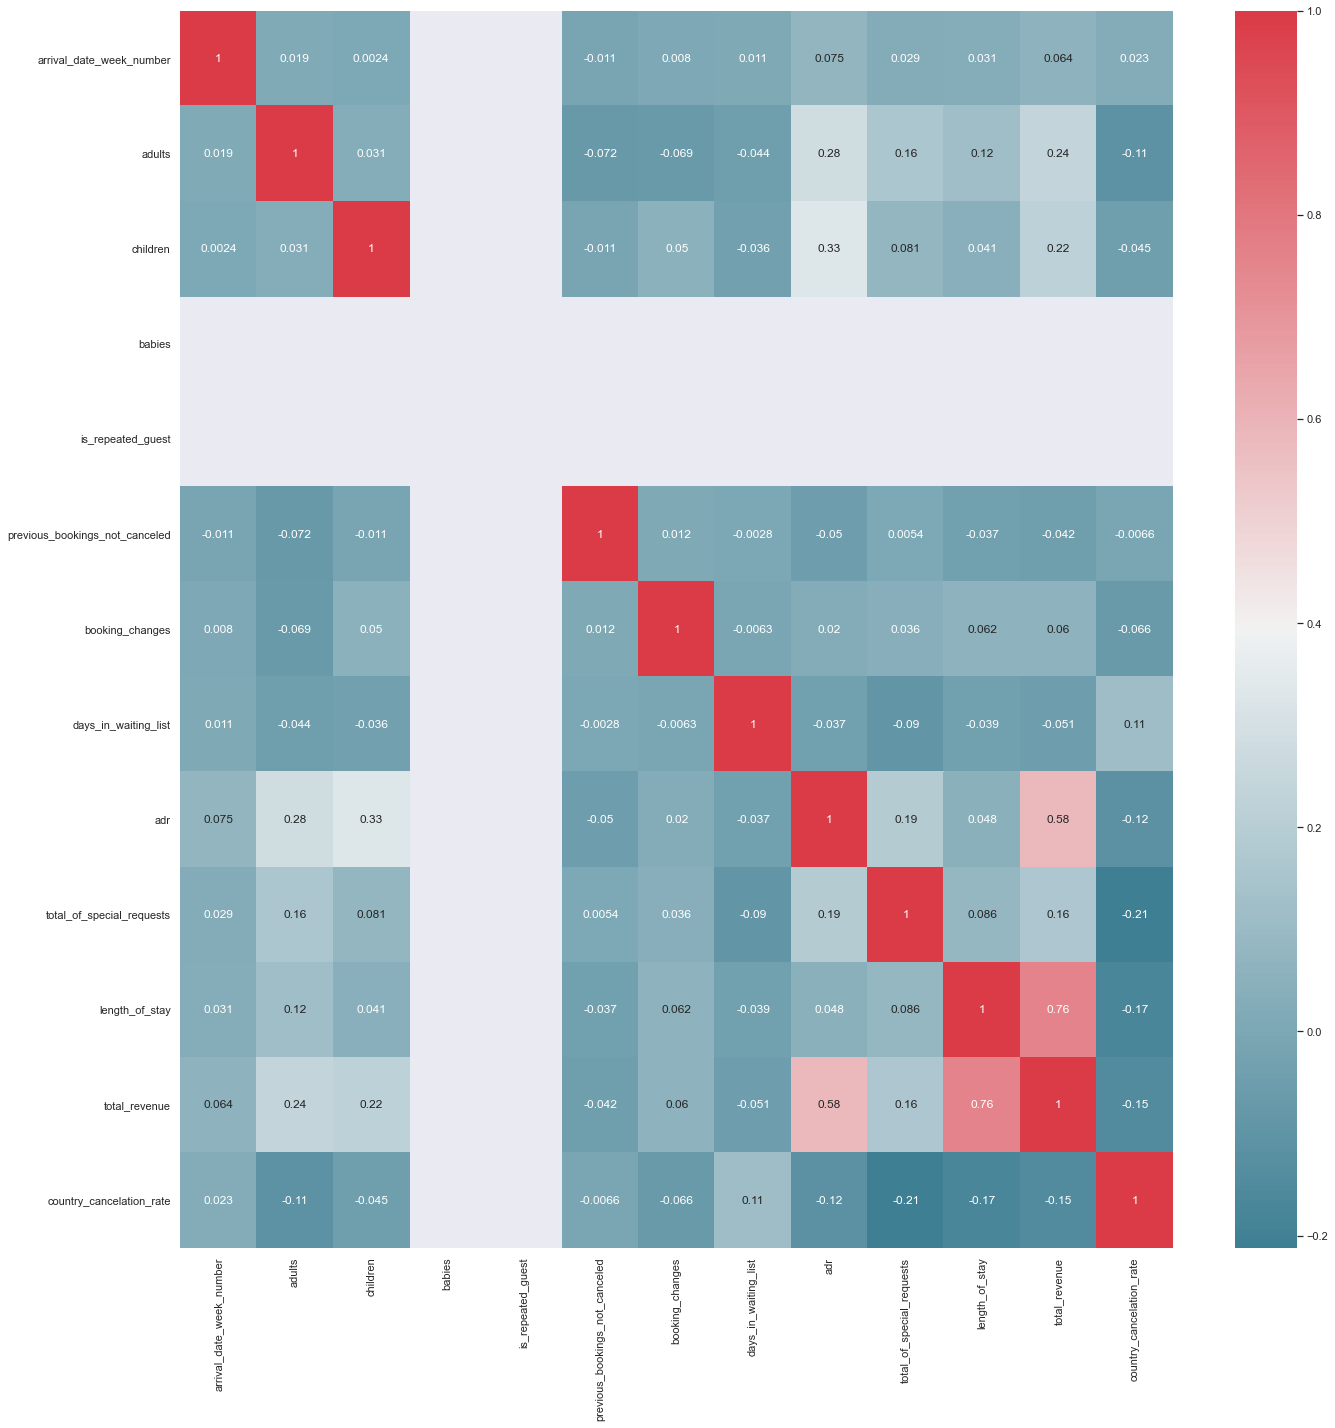

In [20]:
# plot the correlation matrix using seaborn

sns.set(style="darkgrid") # one of the many styles to plot using
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(hotel_no_outliers[hotel_continuous].corr(), cmap=cmap, annot=True)

f.tight_layout()

    # source:
    # copied from asynch notebook

Correlation Matrix:

The correlations matrix plot using the source data sans outliers tells us that there are not many strong relationships between the continuous features. We do observe some colinearity between `length_of_stay` and `total_revenue`, but that is because `total_revenue` is a product of `length_of_stay`.

We will proceed without reducing or combining dimensions any further than we already have as noted below:
```python
# drop the temp columns created in order to create `country_cancelation_rate`
hotel = hotel.drop(['country_count','cancelations','is_canceled_int'], axis=1)


# dropping redundant date columns as this data is now available in `arrival_date`
hotel = hotel.drop(['arrival_date_year','arrival_date_month','arrival_date_day_of_month'], axis=1)


# dropping redundant stay length columns as this data is now available in 
# `stays_in_week_nights_cat` and `stays_in_weekend_nights_cat`
hotel = hotel.drop(['stays_in_week_nights','stays_in_weekend_nights'], axis=1)


# dropping redundant columns that changed to boolean or categorical or in grouped attributes
hotel = hotel.drop(['company','agent', 'lead_time', 'country', 
                    'previous_cancellations', 'required_car_parking_spaces'], axis=1)

# dropping redundant columns `reservation_status` as it's nearly identical to `is_canceled` - the target in classification
hotel = hotel.drop(['reservation_status'], axis=1)
```

# Data Preparation Part 2

### Describe the final dataset that is used for classification/regression (descriptions of variables included)

# Modeling and Evaluation 1

#### Choose and explain your evaluation metrics you will use. Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

> For our classification task, the target variable of cancelations versus non-cancelations is unbalanced (~30/70) so it will be a better choice to use F1 score - which is the harmonic mean of Recall and Precision - versus the single metrics themselves. We will also use accuracy to compare our model runs. 

> For our regression task we are going to predict length of stay (length_of_stay). We chose regression because the number of nights guests stayed at the hotel length_of_stay is a continous variable.   We will compare against the metrics of RMSE or mean absolute error. We will use RMSE because this metric penalizes large errors in the model (due to squaring first) and having a large error on a predicted length of stay may be catastrophic to the businesses uses of the model. 

# Modeling and Evaluation Part 2

#### Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?) Explain why your chosen method is appropriate or use more than one method as appropriate.

> We will measure the effectiveness of this classification model by using Stratified 10-fold cross validation. The count of cancelations versus non-cancelations is unbalanced (~30/70) and we want to make sure that each fold maintains the same balance as the source data.

> We will measure the effectiveness of this regression model by using 10-fold cross validation.

# Modeling and Evaluation 3

Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). 

### Classification Task: KNN, Logistic, NB

#### Feature Selection - Classification
We will use a RandomForest and RFECV for classification for feature selection. For this, we will use `roc_auc` scoring.

### Regression Task: KNN, OLS, Random Forest

We will use Gridsearch CV to tune the hyperparameters of each model. The CV object passed to the gridsearch for each regressor is the KFold `cv_reg` object. We do not need a stratified cv object for our regressors because our target is continous. Once the hyperparameters have been tuned, the best estimator according to the gridsearch is fitted to the training data and scored -  by RMSE -  on the test set. The best model will be selected by taking the one with the smallest RMSE. However, other metrics such as time, need to re-train, scalability, and the trade-offs from these will also be discussed. 

The GridsearchCV is scoring using the `neg_root_mean_squared_error` or negated RMSE which is just the opposite signed RMSE. When we score the test set we are using the `np.sqrt(metrics.mean_squared_error)` to get the postive RMSE.

#### Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms! (Hyperparameter tuning and gridsearchcv)

#### Hyperparameter Tuning Random Forest Regressor

The below code block uses Gridsearch CV to search 24 model combinations 3 times a piece composed of 4 sets of hyperparameters. 

`n_estimators`: The amount of trees created and used to estimate the target, we used 50 and 100.

`criterion`: the metric which measures the quality of a split - either mean squared error or mean absolute error

`max depth`: the maximum number of end leaf nodes. We used:  

    None - splits all the way until all leaves are pure or until there are no longer enough samples to split  
    
    25 - Max of 25 end leaf nodes

`max_features`: The number of features considered when looking for the best split.  

    Auto: max features = total number of features in dataset,  
    
    Sqrt: max features = sqrt(total number of features),  
    
    Log2: max features = log2(total number of features)

Due to the nature of the model and the compute time involved this Gridsearch was run with 3 folds instead of 10.

In [84]:
%%time
from sklearn.ensemble import RandomForestRegressor

# Fitting 3 folds for each of 24 candidates, totalling 72 fits
# {'criterion': 'mse', 'max_depth': 25, 'max_features': 'auto', 'n_estimators': 100}
# -0.14862435264929744
# RandomForestRegressor(max_depth=25, n_jobs=-1, random_state=42)


from sklearn.ensemble import RandomForestRegressor
# Model Tree Regression
RF_Reg = RandomForestRegressor(n_jobs=-1, bootstrap=True, random_state=42)

# CV Object
folds = KFold(n_splits=3, shuffle=True, random_state=42)


# Hyperparameters to test
param_grid = {
    'n_estimators':[50, 100], # 2
    'criterion':['mse', 'mae'], # 2
    'max_depth':[25, 60], # 2
    'max_features' : ['auto', 'sqrt', 'log2'] # 3
}

# Gridsearch the hyperparameters
CV_rfc_RF_Reg = GridSearchCV(estimator=RF_Reg, param_grid=param_grid, cv=folds,
                      scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)

# Fitting and priniting results of the gridsearch
CV_rfc_RF_Reg.fit(train_data_reg, train_target_reg)
print(CV_rfc_RF_Reg.best_params_)
print(CV_rfc_RF_Reg.best_score_)
print(CV_rfc_RF_Reg.best_estimator_)

# Re-modeling using best Hyperparameters
RF_Reg = CV_rfc_RF_Reg.best_estimator_


# # Fitting and scoring the best model
# RF_Reg.fit(train_data_reg, train_target_reg.values.ravel())
 
# Get predictions
yhat = RF_Reg.predict(train_val_data_reg)

# Results of Best estimator
print("RMSE is:", np.sqrt(metrics.mean_squared_error(train_val_target_reg, yhat)))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 239.1min finished


{'criterion': 'mse', 'max_depth': 25, 'max_features': 'auto', 'n_estimators': 100}
-0.14862435264929744
RandomForestRegressor(max_depth=25, n_jobs=-1, random_state=42)
RMSE is: 3.2909188988888434
Wall time: 3h 59min 12s


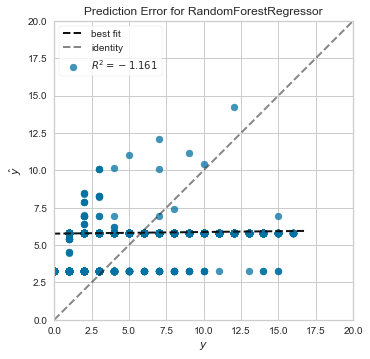

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [85]:
from yellowbrick.regressor import prediction_error

# Instantiate the linear model and visualizer
model = RF_Reg

visualizer = PredictionError(model)

visualizer.fit(train_data_reg, train_target_reg)  # Fit the training data to the visualizer
visualizer.score(train_val_data_reg, train_val_target_reg) # Evaluate the model on the validation data
plt.xlim([0,20])
plt.ylim([0,20])
visualizer.show()

#### Hyperparameter Tuning OLS Ridge Regression

The below code block uses Gridsearch CV to search 48 models 10 times a piece across 2 hyperparameters

`alpha`: Regularization strength. Larger values are stronger. Reduces varaiance in estimates

`solver`: What equation or algorithm the ridge will use:

    svd: Singular Value Decomposition 
    cholesky: uses linalg functions to obtain a close formed solution 
    lsqr: regularized least squares - usually fastest, uses and iterative procedure  
    sparse_cg: Conjugate Gradient Solver, better for large scale data  
    auto: method auto determined by data  
    saga: Stochastic Average Gradient Descent with L1 regularization support  
    

The Ridge method is by far the fastest regressor we used. 

In [20]:
%%time
# Model Ridge Regression
OLS_Ridge = Ridge(random_state=42)

# CV Object
folds = KFold(n_splits=10, shuffle=True, random_state=42)

# Hyperparameters to test
param_grid = {
    'alpha':[.001, .01, .1, 1, 5, 10, 100, 1000],
    'solver':['svd', 'cholesky', 'lsqr', 'sparse_cg', 'auto', 'saga']           
}

# Gridsearch the hyperparameters
CV_rfc_OLS_Ridge = GridSearchCV(estimator=OLS_Ridge, param_grid=param_grid, cv=folds,
                      scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)

# Fitting and priniting results of the gridsearch
CV_rfc_OLS_Ridge.fit(train_data_reg, train_target_reg)
print(CV_rfc_OLS_Ridge.best_params_)
print(CV_rfc_OLS_Ridge.best_score_)
print(CV_rfc_OLS_Ridge.best_estimator_)

# Setting model to use best Hyperparameters from gridsearchCV  
OLS_Ridge = CV_rfc_OLS_Ridge.best_estimator_

# Fitting and scoring the RFECV'd best model
OLS_Ridge.fit(train_data_reg, train_target_reg)

yhat = OLS_Ridge.predict(train_val_data_reg)

# Results of Best estimator
print("RMSE is:", np.sqrt(metrics.mean_squared_error(train_val_target_reg, yhat)))

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.2min finished


{'alpha': 10, 'solver': 'cholesky'}
-0.8818409258614267
Ridge(alpha=10, random_state=42, solver='cholesky')
RMSE is: 0.8838789933914836
Wall time: 1min 13s


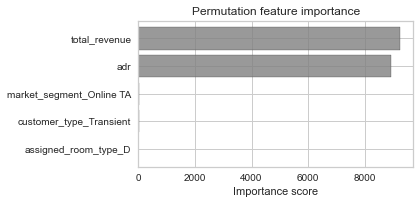

In [74]:
# https://aegis4048.github.io/mutiple_linear_regression_and_visualization_in_python
import rfpimp
imp = rfpimp.importances(OLS_Ridge, train_val_data_reg, train_val_target_reg)
fig, ax = plt.subplots(figsize=(6, 3))

imp = imp.head()
ax.barh(imp.index, imp['Importance'], height=0.8, facecolor='grey', alpha=0.8, edgecolor='k')
ax.set_xlabel('Importance score')
ax.set_title('Permutation feature importance')
plt.gca().invert_yaxis()

fig.tight_layout()

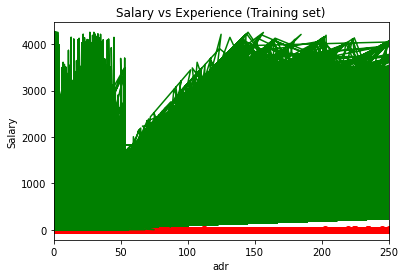

In [53]:
# plt.scatter(data_reg.total_revenue, target_reg, color = "red")
# plt.plot(data_reg, OLS_Ridge.predict(data_reg), color = "green")
# plt.title("(Training set)")
# plt.xlabel("adr")
# plt.xlim([0,250])
# plt.ylabel("LoS")
# plt.show()

#### Residual and Prediction Error Plot for `OLS_Ridge`

Seen below the plot of the residuals has a very evident trend. This isnt what we want to see from our residuals. We would like them to be centered in a random cloud. Further, the histogram of residuals is off the charts.  This implies that this model is not well suited to the problem at hand, and that a non-linear model would likely perform better. 

Below the residuals is a predicition error plot. The model seems to be missing the aggregate bunch near 0.

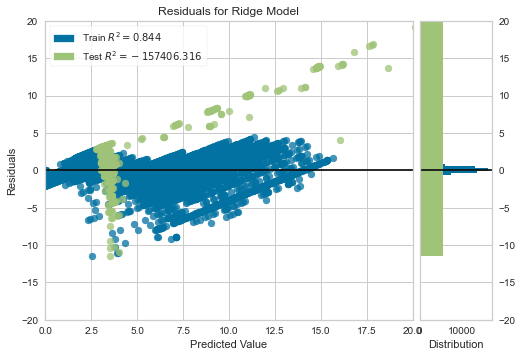

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [83]:
# https://www.scikit-yb.org/en/latest/api/regressor/residuals.html
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
model = OLS_Ridge


visualizer = ResidualsPlot(model, hist=True, qqplot=False,is_fitted=True)

visualizer.fit(train_data_reg, train_target_reg)  # Fit the training data to the visualizer
visualizer.score(train_val_data_reg, train_val_target_reg) # Evaluate the model on the validation data
plt.xlim([0,20])
plt.ylim([-20,20])
visualizer.show()

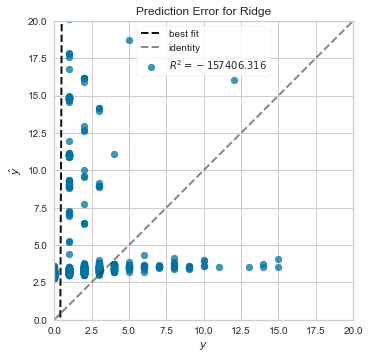

<AxesSubplot:title={'center':'Prediction Error for Ridge'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [78]:
from yellowbrick.regressor import prediction_error

# Instantiate the linear model and visualizer
model = OLS_Ridge

visualizer = PredictionError(model)

visualizer.fit(train_data_reg, train_target_reg)  # Fit the training data to the visualizer
visualizer.score(train_val_data_reg, train_val_target_reg) # Evaluate the model on the validation data
plt.xlim([0,20])
plt.ylim([0,20])
visualizer.show()


#### Hyperparameter tuning KNN

The below code block uses Gridsearch CV to test 48 models 10 times a piece across 4 sets of hyperparameters.

`algorithm`: The computing process employed by the KNN regressor.  

    Auto: 
    ball_tree: 
    kd_tree: 
    brute: 

`weights`: How points in the neighborhood are weighted
   uniform: all points in the neighborhood recieve equal weight regardless of distance  
   
`distance`: all points in the neighborhood are weighted by distance away from the observation in question. Closer points weigh more.
    
`n_neighbors`: How many points to include in each neighborhood.

In [21]:
%%time
 
# Model KNN Regression
Knn_Reg = KNeighborsRegressor(n_jobs=-1)

# CV Object
folds = KFold(n_splits=10, shuffle=True, random_state=42)

# Hyperparameters to test
param_grid = {
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], # 4
    'weights':['uniform', 'distance'], # 2
    'n_neighbors': [1,3,5,7,9,11]
}

# Gridsearch the hyperparameters
CV_rfc_Knn_Reg = GridSearchCV(estimator=Knn_Reg, param_grid=param_grid, cv=folds,
                      scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=3)

# Fitting and priniting results of the gridsearch
CV_rfc_Knn_Reg.fit(train_data_reg, train_target_reg)
print(CV_rfc_Knn_Reg.best_params_)
print(CV_rfc_Knn_Reg.best_score_)
print(CV_rfc_Knn_Reg.best_estimator_)

# Re-modeling using best Hyperparameters and running through Recursive Feature Elimination
Knn_Reg = CV_rfc_Knn_Reg.best_estimator_

# rfecv_Knn_Reg = RFECV(estimator=Knn_Reg, step=1, cv=folds, 
#                         scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)

# Fitting and scoring the RFECV'd best model
Knn_Reg.fit(train_data_reg, train_target_reg)

yhat = Knn_Reg.predict(train_val_data_reg)

# Results of Best estimator
print("RMSE is:", np.sqrt(metrics.mean_squared_error(train_val_target_reg, yhat)))

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 45.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 96.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 100.9min finished


{'algorithm': 'brute', 'n_neighbors': 7, 'weights': 'distance'}
-1.0511532298673463
KNeighborsRegressor(algorithm='brute', n_jobs=-1, n_neighbors=7,
                    weights='distance')
RMSE is: 0.48000810755428686
Wall time: 1h 43min 19s


#### Prediction Error Plot Knn_Reg

Here we can see the the KNN model performs quite a bit better than the Ridge model. Our predicitions are quite a bit more cenetered and have a much better R2.

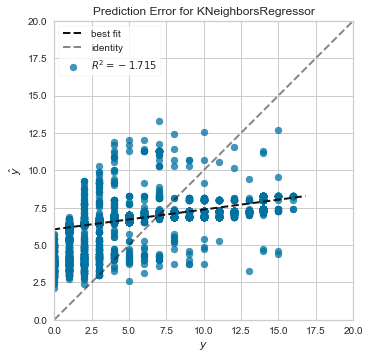

<AxesSubplot:title={'center':'Prediction Error for KNeighborsRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [80]:
# Instantiate the model and visualizer
model = Knn_Reg

visualizer = PredictionError(model)

visualizer.fit(train_data_reg, train_target_reg)  # Fit the training data to the visualizer
visualizer.score(train_val_data_reg, train_val_target_reg) # Evaluate the model on the validation data
plt.xlim([0,20])
plt.ylim([0,20])
visualizer.show()

In [25]:
%%time
# Using paired_ttest_5x2cv to generate statistics on the difference in model performance.
t, p = paired_ttest_5x2cv(estimator1=OLS_Ridge,
                         estimator2=Knn_Reg,
                         X=train_val_data_reg, y=train_val_target_reg,
                         scoring='neg_mean_squared_error',
                         random_seed=42) 

print('t statistic: %.3f' % t)
print('p value: %.7f' % p)

t statistic: 14.498
p value: 0.0000282


In [ ]:
%%time
# Using paired_ttest_5x2cv to generate statistics on the difference in model performance.
t, p = paired_ttest_5x2cv(estimator1=OLS_Ridge,
                         estimator2=Knn_Reg,
                         X=train_val_data_reg, y=train_val_target_reg,
                         scoring='neg_mean_squared_error',
                         random_seed=42) 

print('t statistic: %.3f' % t)
print('p value: %.7f' % p)

# Modeling and Evaluation Part 4

#### Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model

> List of Visualizations:
>    - ROC (Classification) 

>    - KNN Viz https://towardsdatascience.com/knn-visualization-in-just-13-lines-of-code-32820d72c6b6

>    - SE Link for Regression Viz https://stats.stackexchange.com/questions/89747/how-to-describe-or-visualize-a-multiple-linear-regression-model

>    - Confusion Matrices as heat maps (Classification) https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

>    - Correlation Matrix heat maps (Regression)
    

# Modeling and Evaluation Part 5

### Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another?

> Better on Metrics?

> Better on Time?

> Sparse vs Non

> Model Specific https://www.quora.com/What-are-the-advantages-of-different-classification-algorithms, https://discuss.analyticsvidhya.com/t/which-one-to-use-randomforest-vs-svm-vs-knn/2897/3, https://towardsdatascience.com/comparative-study-on-classic-machine-learning-algorithms-24f9ff6ab222

####  Is the difference significant with 95% confidence? proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.

> Comparing on Statistics: https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/

# Modeling and Evaluation Part 6

### Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task

### Do we need to this for every model iteration? ASK HIM ON THURSDAY

# Deployment NEIL GOT THIS

### How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)?

> Have a discussion about scope of use

### How would you measure the model's value if it was used by these parties?

###  How would your deploy your model for interested parties? What other datashould be collected? How often would the model need to be updated, etc.?

# Exceptional Work